<a href="https://colab.research.google.com/github/LinjingBi/practice-nn-0-to-hero/blob/master/L4_makemore_part3_BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In L3, we implemented a MLP, and run backpropagations to reduce the loss to a number. But if we look at the loss plot, it seems loss always started with a dramatic values(like 20, 30) and then reduced to 5,6,3,2,etc. And it is caused by the random initialization of weights and bias in each layers. So this lecture is going to introduce some ways to avoid such case.



In [101]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [102]:
with open('names.txt') as f:
  names = f.read().splitlines()
vocab = sorted(list(set("".join(names))))
vocab = ['.'] + vocab
in2str = {i: j for i, j in enumerate(vocab)}
str2in = {j: i for i, j in in2str.items()}

blocks = 3
def build_data(data):
  xs = []
  ys = []

  for word in data:
    nxt = [0] * blocks
    for l in word + '.':
      x = str2in[l]
      xs.append(nxt)
      ys.append(x)

      nxt = nxt[1:] + [x]
  return torch.tensor(xs), torch.tensor(ys)


# 80% training data, 10% dev data, 10% test data(don't touch)

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

X_tr, Y_tr = build_data(names[:n1])
X_dev, Y_dev = build_data(names[n1:n2])
X_test, Y_test = build_data(names[n2:])

print("tr{}{}, dev{}{}, tst{}{}".format(X_tr.shape, Y_tr.shape,
                                        X_dev.shape, Y_dev.shape,
                                        X_test.shape, Y_test.shape))




trtorch.Size([182625, 3])torch.Size([182625]), devtorch.Size([22655, 3])torch.Size([22655]), tsttorch.Size([22866, 3])torch.Size([22866])


In [104]:
# train using X_tr and Y_tr
# in this step, to avoid the hocket shape of Loss, and have a more smooth gradient descent,
# we need to apply kaiming normal initilization to the weights in hidden layer
# kaiming's paper: https://arxiv.org/pdf/1502.01852
# pytorch: https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

batch_size = 32
embed_dim = 10
l1_num = 200
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((len(vocab), embed_dim), generator=g)

# hidden layer
W1 = torch.randn((blocks*embed_dim, l1_num), generator=g) * (5/3) / (blocks*embed_dim) ** 0.5 # sqr(fan_in)
# b1 = torch.randn(l1_num, generator=g) * 0.01

# produce logits for softmax, can be seen as an output layer
# here to achieve a uniform distribution at the beginning(assume all the chars are equally possible)
# we also need to scale down the weights here, make less confident.
W2 = torch.randn((l1_num, len(vocab)), generator=g) * 0.01
b2 = torch.rand(len(vocab), generator=g) * 0

# another issue is the tanh, the activation function after linear pre-activation L1
# tanh tends to squeeze the values in the middle, and for the tails(big ones), are all set to ~-1/1,
# and those bigs values in the gradient descent will produce alot zero gradients, which makes teh backward pass less meaningful...
# so here we implement batch normalization to normalize the inputs values of tanh to a normal-liked distribution
# BatchNorm parameters, for normalization, not dot product
# interesting point here is batch is actually normilzing between different inputs. Not something from the network itself like weights or biases.
# basically it wants the inputs follow a normal-liked distribution. and it works :)
# Batch norm paper: https://arxiv.org/pdf/1502.03167
bngain = torch.ones((1, l1_num))
bnbias = torch.zeros((1, l1_num))
# normal distribution mean 0, std 1
bnmean_running = torch.zeros((1, l1_num)) # save for inference
bnstd_running = torch.ones((1, l1_num)) # save for inference

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True # don't forget require grad!!!!!


12097


In [7]:
max_steps = 200000
lossi = []
# lets kick off the training
for i in range(max_steps):
  # prepare input batch
  nums = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g)
  X = X_tr[nums]

  # forward pass
  xemb = C[X] # embed the characters into vectors
  # hidden layer - linear layer
  hpreact = xemb.view(xemb.shape[0], -1) @ W1 # + b1 # canceled in batch norm
  # hidden layer - batch norm layer
  # ---------------------------------------------------------
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
  hpreact = bngain*(hpreact-bnmean)/bnstd + bnbias  # it is broadcasting(element-wise operation), not dot product!
  with torch.no_grad():  # update the runtime mean and std for inference
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd
  # ---------------------------------------------------------
  h = torch.tanh(hpreact)  # hidden layer - non-linear layer tanh
  logits = h @ W2 + b2  # output layer
  loss = F.cross_entropy(logits, Y_tr[nums])  # loss func

  # backward pass
  for p in parameters:
    p.grad = None  # zero grad
  loss.backward()

  # gradient descent
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())


      0/ 200000: 3.2976
  10000/ 200000: 2.1286
  20000/ 200000: 2.3761
  30000/ 200000: 2.2152
  40000/ 200000: 2.3531
  50000/ 200000: 1.6970
  60000/ 200000: 1.9186
  70000/ 200000: 2.4664
  80000/ 200000: 2.2790
  90000/ 200000: 2.2336
 100000/ 200000: 2.1772
 110000/ 200000: 1.9863
 120000/ 200000: 1.9561
 130000/ 200000: 2.0185
 140000/ 200000: 2.1753
 150000/ 200000: 2.2481
 160000/ 200000: 2.0359
 170000/ 200000: 2.3937
 180000/ 200000: 2.3475
 190000/ 200000: 1.8571


tensor(2.1592)

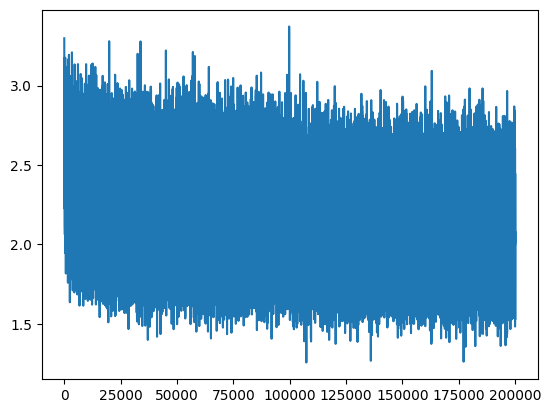

In [8]:
plt.plot(lossi)
# torch.tensor(lossi).mean()

In [9]:
# loss for all the train data or dev data or test data
def split_loss(mode):
  data = {
      "test": (X_test, Y_test),
      "dev": (X_dev, Y_dev),
      "train": (X_tr, Y_tr)
  }
  X = data[mode][0]
  with torch.no_grad():
    embx = C[X]  # embedding
    hpreact = embx.view(embx.shape[0], -1) @ W1  # linear layer
    hpreact = bngain*(hpreact - bnmean_running)/bnstd_running + bnbias  # batch norm
    h = torch.tanh(hpreact)  # non-linear layer pytorch
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, data[mode][1])  # loss
  print(f"{mode} {loss}")

split_loss('train')
split_loss('dev')

train 2.067437171936035
dev 2.1070668697357178


In [10]:
# Pytorchifying everything...

In [110]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.w = torch.randn((fan_in, fan_out), generator=g)/ fan_in ** 0.5
    self.b = torch.zeros((fan_out,)) if bias else None

  def __call__(self, x):
    self.out = x @ self.w
    if self.b:
      self.out += self.b

    return self.out

  def parameters(self):
    return [self.w] + ([self.b] if self.b else [])


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.train = True
    # parameters (train with backward)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (train with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.train:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean)/torch.sqrt(xvar+self.eps)
    self.out = self.gamma*xhat + self.beta
    if self.train:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


In [131]:
# lets construct MLP

n_emb = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((len(vocab), n_emb), generator = g)
layers = [
    Linear(n_emb*blocks, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, len(vocab), bias=False), BatchNorm1d(len(vocab)),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    # all other layers: apply gain. 5/3 is the gain for non-linear tanh
    if isinstance(layer, Linear):
      layer.w *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47024


In [132]:
# start training
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  ids = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g)
  Xs, Ys = X_tr[ids], Y_tr[ids]
  # Xs, Ys = torch.tensor([[0] * blocks]), Y_tr[ids]

  # forward pass
  emb = C[Xs]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
    # print(x)
  loss = F.cross_entropy(x, Ys)

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # store layer output grad only for visualizing, debug only
  for p in parameters:
    p.grad = None
  loss.backward()

  # gradient descent
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break





      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

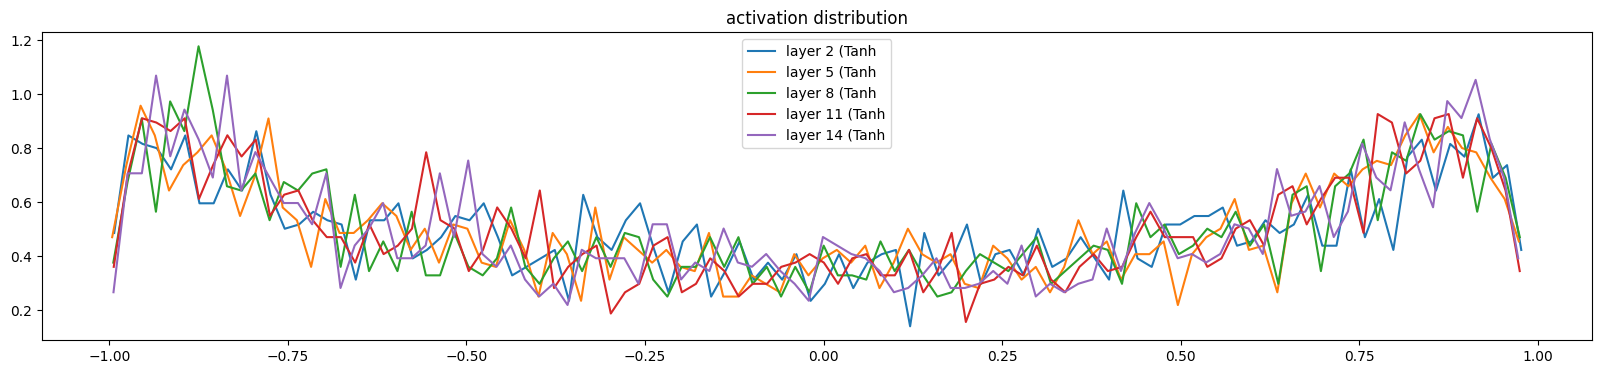

In [133]:
# visualize histograms from first 1000 times of training to see the inluence of initialization
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())  # hx[-1] is grad_fn=<NotImplemented>, hence skip. Tensor.detach returns a new tensor out of the graph, and will never require gradient
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682959e-03
layer 5 (      Tanh): mean +0.000000, std 3.262612e-03
layer 8 (      Tanh): mean -0.000000, std 2.973733e-03
layer 11 (      Tanh): mean +0.000000, std 2.741114e-03
layer 14 (      Tanh): mean +0.000000, std 2.584294e-03


Text(0.5, 1.0, 'gradient distribution')

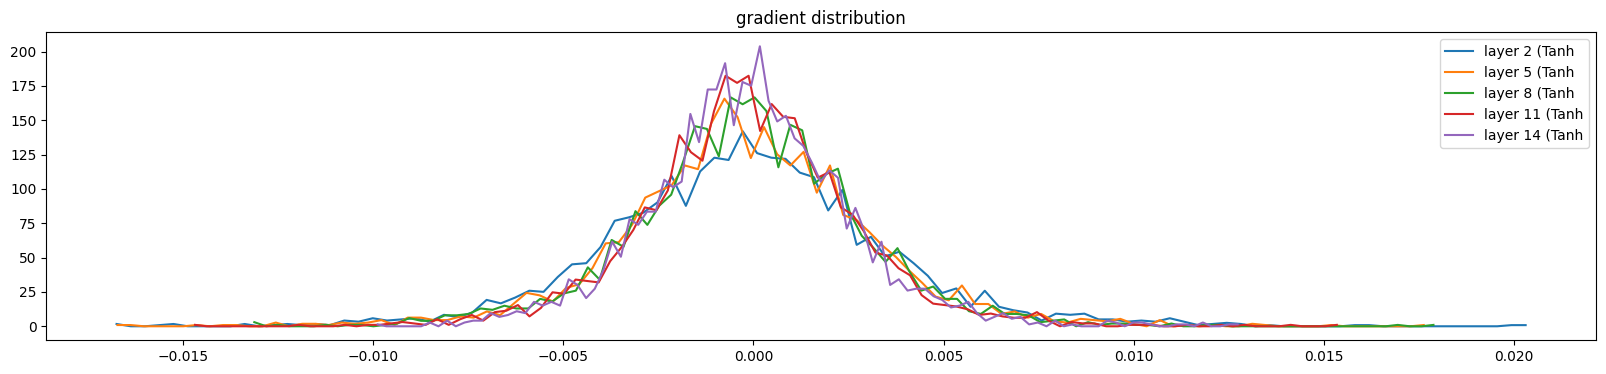

In [134]:
# visualize histograms first 1000 times of training to see the inluence of initialization
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.019889e-02 | grad:data ratio 1.018849e-02
weight  (30, 100) | mean +0.000092 | std 8.238440e-03 | grad:data ratio 2.635842e-02
weight (100, 100) | mean +0.000031 | std 7.318122e-03 | grad:data ratio 4.377151e-02
weight (100, 100) | mean -0.000019 | std 6.662030e-03 | grad:data ratio 3.949900e-02
weight (100, 100) | mean -0.000019 | std 5.821521e-03 | grad:data ratio 3.468164e-02
weight (100, 100) | mean +0.000053 | std 5.445301e-03 | grad:data ratio 3.243370e-02
weight  (100, 27) | mean -0.000165 | std 1.046845e-02 | grad:data ratio 6.281269e-02


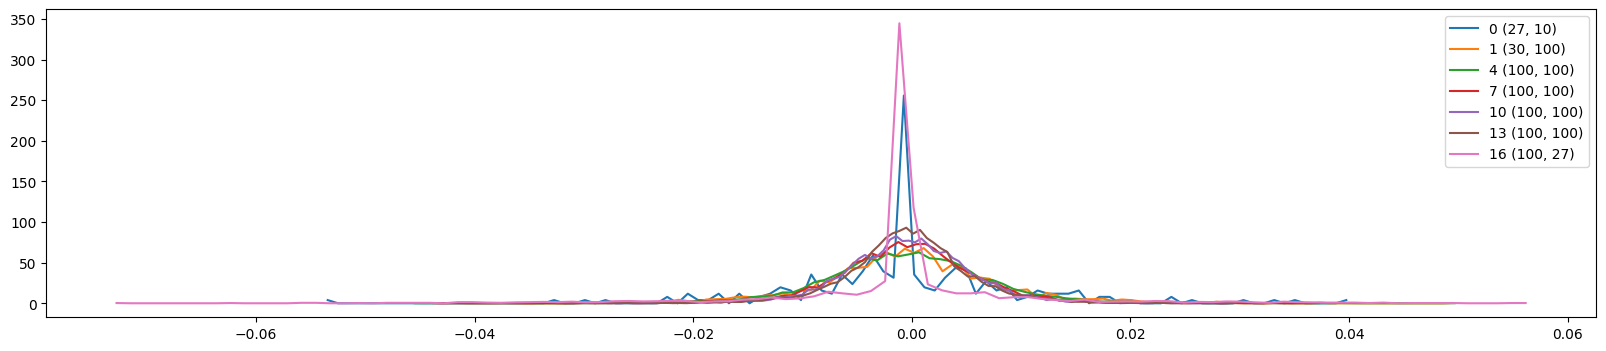

In [135]:
# visualize histograms first 1000 times of training to see the inluence of initialization
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)

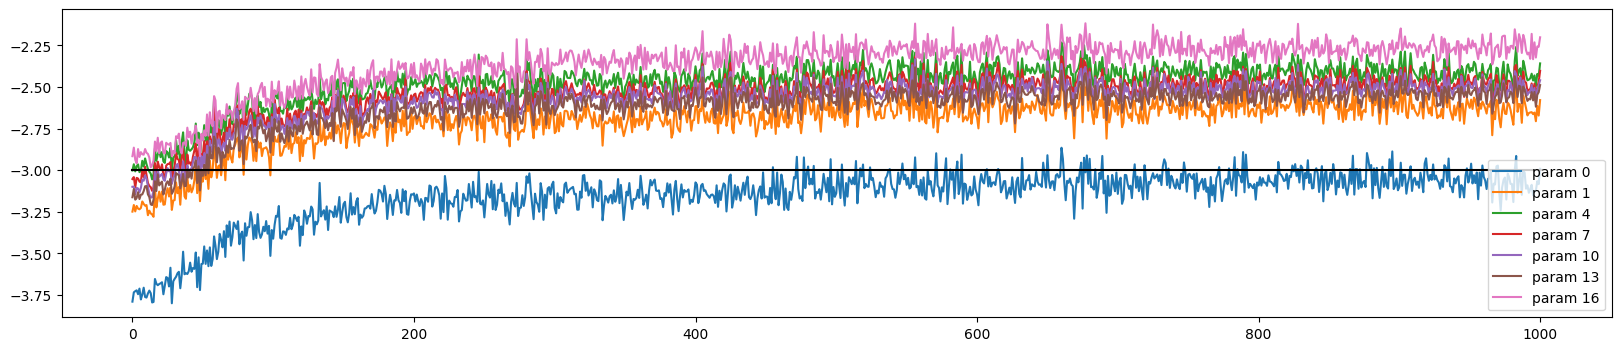

In [136]:
# plot from first 1000 times of training to see the inluence of initialization
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [125]:
# after full train
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_tr, Y_tr),
    'val': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.train = False  # trun off train mode for BM layers, switch to updated mean and var
split_loss('train')
split_loss('val')

train 1.9569120407104492
val 2.083991050720215


In [127]:
# sample from the model after full train
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * blocks # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        layer.train = False  # trun off train mode for BM layers, switch to updated mean and var
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(in2str[i] for i in out)) # decode and print the generated word

mora.
kayah.
see.
madhayla.
reisha.
endraig.
adelynnelin.
shyloni.
eden.
est.
naraelyziah.
kalin.
shubergiagrael.
kinleen.
jerenterian.
brence.
ryyah.
fael.
yuva.
myson.
